# Official Disappearance Notice Classifier

### The purpose of this notebook is to classify posts scraped from Facebook based on whether they contain an official disappearance notice from the Mexican government. 
### This is accomplished by loading previously-downloaded posts stored on a local drive, as well as images stored either in AWS or a local drive. Images are then featurized and a classifier is built and tested against a small hand-labeled subset.

## Imports

In [60]:
import pandas as pd
import numpy as np
import os
import json
import string as str_lib
from pathlib2 import Path
import math
from shutil import copy

# sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from skimage import feature, color
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold

# OCR/image recognition
from PIL import Image
import skimage
import pytesseract
#import face_recognition

# AWS
#import boto3

# Spacy
import spacy
nlp = spacy.load('en_core_web_md')

# Altair
import altair as alt
alt.renderers.enable("notebook") #change to "default" for Jupyter Lab

# Keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

## Load All Facebook posts/comments scraped by NodeXL

In [3]:
data_directory="../Data/NodeXL/"
allFiles = os.listdir(data_directory)
files = []
#print allFiles
for file in allFiles:
    if file.endswith('.xlsx'):
        files.append(file)
print(len(files))

61


## Parse files and combine into a single dataframe

In [4]:
#thanks to Valerie for this
def build_frame_from_raw_files(file):
    #print "Opening file..." + str(file)
    spreadsheet = pd.ExcelFile(data_directory+file)
    #print "Successfully opened file!"

    #print "Gathering edge connections....."
    edges = spreadsheet.parse("Edges", header=1, usecols=[0,1])
    #Create dictionary
    edges_dict = {}
    for index, row in edges.iterrows():
        #print row["Vertex 1"]
        edges_dict[row["Vertex 1"]] = row["Vertex 2"]
    #print edges_dict

    #print "Gathering vertices....."
    vertices = spreadsheet.parse("Vertices", header=1)
    #Add the appropriate dictionary entry to each row by iterating through each row
    # and adding the row plus the new Parent column to a new dataset
    joined_df = vertices
    joined_df['Parent'] = joined_df['Vertex'].map(edges_dict)
    if file.find("_") > -1:
        joined_df["Group"] = file[:file.find("_")-1]
    else:
        joined_df["Group"] = file[:file.find(".xlsx")-1]
    #joined_df["Month"] = file[-8:-5]  
    #print joined_df
    return joined_df

In [5]:
#Parse each file in the selected directory
df_list = [build_frame_from_raw_files(file) for file in files]
raw_df = pd.concat(df_list)

//anaconda3/envs/mexico_missing_persons/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


## Clean missing data and rename columns

In [6]:
raw_df = raw_df.rename(columns={"Vertex":"Post Id"})

In [11]:
#remove bad rows
all_df = raw_df.set_index("Post Id", drop=False)
raw_df["Short Id"] = raw_df["Post Id"].apply(lambda x: x.replace("_",""))
#do the parentless row check twice to get rows that are children of the parentless comments
all_df["Bad Row"] = all_df.apply(lambda row: False if row["Vertex Type"] == "Post"\
                                 or pd.notnull(row["Parent"]) else True, axis=1)
bad_rows_df = all_df[all_df["Bad Row"] == True]
all_df["Bad Row"] = all_df.apply(lambda row: True if row["Bad Row"] is True\
                                 or row["Parent"] in bad_rows_df.index else False, axis=1)
all_df = all_df[all_df["Bad Row"] == False]
all_df = all_df.reset_index(drop = True)

## Get hand-labeled dataset and join with posts

In [13]:
#get gold standard labels
with open('./gold_labels_2.csv') as f:
    gold_labels = pd.read_csv(f, index_col="Id").to_dict(orient="index")
    all_df["Gold Label"] = all_df["Post Id"].apply(lambda x: (1 if gold_labels.get(x)["Gold_Label"]=="Y" else 0)\
                                                  if x in gold_labels else None)

In [14]:
all_df.groupby("Gold Label").size()

Gold Label
0.0    1173
1.0     154
dtype: int64

## More Column Creating and Formatting

In [15]:
all_df["Date"] = all_df.apply(lambda row: row["Post Date"] if not pd.isnull(row["Post Date"])\
                              else row["Comment Date"],\
                              axis=1)
all_df["Image URL"]  = all_df.apply(lambda row: row["Image"] if not pd.isnull(row["Image"])\
                              else row["Attachment URL"],\
                              axis=1)
all_df["Has Image"] = all_df["Image URL"].apply(lambda x: pd.notnull(x) and len(x) > 10)

In [16]:
post_df = all_df.loc[all_df["Vertex Type"]=="Post",["Group", "Post Id", "Short Id", "Gold Label","Has Image"]].copy()

## Define methods for featurizing, loading, and parsing images and OCR Text

In [18]:
def process_image(img, transform):
    if img is None or img.shape[0] == 0:
        return None
    elif transform == "hog":
        try:
            return feature.hog(img, feature_vector=True, multichannel=True,\
                                   pixels_per_cell=(16,16))
        except:
            return None
    elif transform == "daisy":
        return feature.daisy(color.rgb2gray(img)).flatten()
    elif transform == "canny":
        return feature.canny(color.rgb2gray(img)).flatten()
    elif transform == "histogram":
        return np.hstack([skimage.exposure.histogram(img[...,c],\
                                                     nbins=20)\
                          for c in [0,1,2]])[0]
    elif transform == "slic":
        return skimage.segmentation.slic(image=img, n_segments=30).flatten()
    elif transform == "corner":
        return feature.corner_moravec(color.rgb2gray(img)).astype(int).flatten()

In [79]:
def get_image_from_file(id, width = 64, height = 64):
    image_path = "./Images/"+str(id)+".jpg"
    if Path(image_path).is_file():
        img = skimage.transform.resize(skimage.io.imread(image_path), (width, height))
        return img
    return None    
#     image_path = "./Images/"+str(id)+".jpg"
#     if Path(image_path).is_file():
#         return Image.open(image_path).resize((256,256)).histogram()
#                     #.getdata())
#     else:
#         return None

In [20]:
def get_ocr_text(id):    
    ocr_text = ""
    image_path = "./Images/"+str(id)+".jpg"
    if Path(image_path).is_file():
        ocr_text = pytesseract.image_to_string(skimage.io.imread(image_path))
        return ocr_text if pd.notnull(ocr_text) else ""
    return ""

In [21]:
def valid_text(x):
    if pd.isnull(x):
        return False
    elif isinstance(x, (int, long, float)):
        return False
    elif len(x) <= 10:
        return False
    elif x == "":
        return False
    else:
        return True

In [23]:
def get_spacy_doc(x):
    if valid_text(x):
        return nlp(x.replace("\n"," ").replace(r"\N"," "))
    else:
        return nlp(u"")

## Call functions above and load image/OCR data

In [ ]:
# download images
# need to supply your own keys here
# don't bother running this if files are already downloaded, as it takes a while
DOWNLOAD_FROM_AWS = False
if DOWNLOAD_FROM_AWS:
    session = boto3.Session(aws_access_key_id=ACCESS_KEY,
                  aws_secret_access_key=SECRET_KEY)
    s3 = session.resource('s3')
    bucket = s3.Bucket('fbcrp-ocr-text')

    for i, s3_file in enumerate(bucket.objects.all()):
        print(i)
        #print s3_file.key
        #print s3_file.key[s3_file.key.find("-")+1:]
        bucket.download_file(s3_file.key, "./Text/"+s3_file.key[s3_file.key.find("-")+1:])

In [24]:
post_df["image_data"] = post_df["Short Id"].apply(lambda x: get_image_from_file(x))

In [ ]:
post_df["ocr_text"] = post_df["Short Id"].apply(lambda x: get_ocr_text(x))

In [ ]:
post_df["ocr_doc"] = post_df["ocr_text"].apply(lambda x: get_spacy_doc(x))

In [ ]:
cleanedOCR = list(post_df["ocr_doc"].apply(lambda x: " ".join([token.lemma_ for token in x\
                                                                   if not token.is_punct and not token.is_stop\
                                                               ])))

In [ ]:
post_df = post_df.reset_index(drop=True)

In [ ]:
#adapted from http://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
ocrVectorizer = CountVectorizer(analyzer='word',
                                 min_df=0.01,
                                 lowercase=True,
                                 token_pattern='[a-zA-Z0-9]{3,}'
                                )
ocr_vectorized = ocrVectorizer.fit_transform(cleanedOCR)

# Materialize the sparse data
ocr_dense = ocr_vectorized.todense()
word_count_df = pd.DataFrame(data=ocr_dense, columns=["OCR_"+x for x in ocrVectorizer.get_feature_names()])
word_count_df.shape

## Try a number of different featurizations of the images

In [ ]:
post_df["canny_data"] = post_df["image_data"].apply(lambda x: process_image(x, "canny"))
post_df["canny0_data"] = post_df["canny_data"].apply(lambda x: None if x is None else\
                                                        np.sum(x.reshape(64,64).astype(int),\
                                                                axis=0))
post_df["canny1_data"] = post_df["canny_data"].apply(lambda x:None if x is None else\
                                                        np.sum(x.reshape(64,64).astype(int),\
                                                                axis=1))

In [29]:
post_df["histogram_data"] = post_df["image_data"].apply(lambda x: process_image(x, "histogram"))

In [30]:
post_df["hog_data"] = post_df["image_data"].apply(lambda x: process_image(x, "hog"))

In [ ]:
post_df["daisy_data"] = post_df["image_data"].apply(lambda x: process_image(x, "daisy"))

In [ ]:
post_df["slic_data"] = post_df["image_data"].apply(lambda x: process_image(x, "slic"))

In [ ]:
post_df["corner_data"] = post_df["image_data"].apply(lambda x: process_image(x, "corner"))

In [ ]:
post_df["has_ocr"] = post_df["ocr_text"].apply(lambda x: 1 if x!="" else 0)

## Use HOG and Histogram Features for classification
### Uncomment lines below to evaluate other featurizations
### OCR was determined to have little predictive power, so the output in word_count_df is ignored here

In [31]:
#filter down to posts with images
#images_df = pd.concat([post_df, word_count_df],axis=1)
images_df = post_df[(post_df["hog_data"].notnull())].copy()

In [34]:
#prep data for classification
num_canny_features = 64
num_all_canny_features = 4096
num_histogram_features = 60
num_hog_features = 324
num_daisy_features = 16200
num_all_slic_features = 4096
num_corner_features = 4096
X_features_to_drop = ["Has Image", "Short Id", "Post Id", "Group", "Gold Label",
                      "image_data", "hog_data", "histogram_data"]
                      #"slic_data","histogram_data", "daisy_data", 
                      #"corner_data","canny_data", "canny0_data", "canny1_data",
                      #"ocr_text", "ocr_doc"]
#kept_features = ["corner_"+str(i) for i in range(num_corner_features)]
# for i in range(num_daisy_features):
#     images_df["daisy_"+str(i)]\
#      = images_df["daisy_data"].apply(lambda x:x[i] if len(x)==num_daisy_features else -1)
# for i in range(num_all_slic_features):
#     images_df["slic_"+str(i)]\
#      = images_df["slic_data"].apply(lambda x:(1 if x[i] else 0)\
#                                      if len(x)==num_all_slic_features else -1)
# for i in range(num_all_canny_features):
#     images_df["canny_"+str(i)]\
#      = images_df["canny_data"].apply(lambda x:(1 if x[i] else 0)\
#                                      if len(x)==num_all_canny_features else -1)
for i in range(num_hog_features):
    images_df["hog_"+str(i)]\
     = images_df["hog_data"].apply(lambda x:x[i] if len(x)==num_hog_features else -1)
# for i in range(num_canny_features):
#     images_df["canny0_"+str(i)]\
#     = images_df["canny0_data"].apply(lambda x:x[i] if x.shape[0]==num_canny_features else -1)
# for i in range(num_canny_features):
#     images_df["canny1_"+str(i)]\
#     = images_df["canny1_data"].apply(lambda x:x[i] if x.shape[0]==num_canny_features else -1)    
for i in range(num_histogram_features):
    images_df["histogram_"+str(i)]\
    = images_df["histogram_data"].apply(lambda x:x[i] if len(x)\
                                        ==num_histogram_features else -1)
# for i in range(num_corner_features):
#     images_df["corner_"+str(i)]\
#     = images_df["corner_data"].apply(lambda x:x[i] if len(x)\
#                                         ==num_corner_features else -1)    

## Prep Train X by filtering to only those records with images and labels

In [35]:
train_X = images_df[(images_df["Gold Label"].isin([0,1]))].copy()
train_Y = train_X.loc[:,"Gold Label"]
train_X.drop(X_features_to_drop, axis=1).head()

,hog_0,hog_1,hog_2,hog_3,hog_4,hog_5,hog_6,hog_7,hog_8,hog_9,...,histogram_50,histogram_51,histogram_52,histogram_53,histogram_54,histogram_55,histogram_56,histogram_57,histogram_58,histogram_59
5,0.225447,0.028094,0.003723,0.000000,0.005366,0.000452,0.004940,0.017739,0.194583,0.225447,...,13.0,13.0,9.0,6.0,6.0,6.0,3.0,2.0,5.0,3.0
41,0.032864,0.011193,0.004284,0.008659,0.241347,0.030587,0.006099,0.002504,0.016721,0.024238,...,35.0,40.0,48.0,53.0,57.0,78.0,129.0,168.0,15.0,15.0
52,0.159232,0.062261,0.024201,0.015355,0.085880,0.032702,0.019525,0.022334,0.129567,0.125462,...,123.0,127.0,130.0,88.0,109.0,98.0,93.0,115.0,83.0,115.0
88,0.044370,0.014540,0.010133,0.009249,0.013609,0.009608,0.025111,0.050909,0.068448,0.080865,...,42.0,50.0,54.0,33.0,34.0,35.0,28.0,19.0,11.0,13.0
116,0.000218,0.000000,0.001096,0.006809,0.036596,0.000159,0.000000,0.000000,0.000000,0.000157,...,50.0,48.0,57.0,81.0,49.0,30.0,78.0,160.0,152.0,2608.0


## Use Random Forest with Recursive Feature Elimination to select best minimal feature set

In [49]:
clsfFeatures = RandomForestClassifier(n_estimators = 100)#class_weight="balanced")

rfe = RFE(estimator=clsfFeatures, step=5, n_features_to_select = 30)
rfe.fit(train_X.drop(X_features_to_drop, axis=1), train_Y)
#list of retained features
kept_feature_ids = rfe.get_support(indices=True)
kept_features = np.array(train_X.drop(X_features_to_drop, axis=1).iloc[:,kept_feature_ids].columns.values)
print(kept_features)

['hog_27' 'hog_34' 'hog_44' 'hog_51' 'hog_73' 'hog_80' 'hog_85' 'hog_108'
 'hog_116' 'hog_162' 'hog_163' 'hog_169' 'hog_183' 'hog_185' 'hog_186'
 'hog_207' 'hog_208' 'hog_215' 'hog_243' 'hog_251' 'hog_301' 'hog_310'
 'hog_319' 'histogram_3' 'histogram_16' 'histogram_18' 'histogram_35'
 'histogram_36' 'histogram_55' 'histogram_56']


## Now run Gradient Boosting model as the actual classifier
### Use K-Fold to evaluate

In [170]:
#K-Fold Evaluation
#clsf = RandomForestClassifier(class_weight="balanced", n_estimators=100,
                              #max_depth=3, min_samples_leaf=10)
clsf = GradientBoostingClassifier(max_depth=3, n_estimators=200)
#clsf = LogisticRegression(C=9)
#clsf=MLPClassifier(max_iter=400)
precisions = {"train":[], "test":[]}
recalls = {"train":[], "test":[]}
accuracies = {"train":[], "test":[]}
aucs = []
roc_dfs = []
for train, test in StratifiedKFold(10).split(train_X.loc[:,kept_features], train_Y):
    clsf.fit(train_X.loc[:,kept_features].iloc[train,:], train_Y.iloc[train])
    predictedTrain = clsf.predict(train_X.loc[:,kept_features].iloc[train,:])
    predictedTest = clsf.predict(train_X.loc[:,kept_features].iloc[test,:])
    precisions["train"].append(metrics.precision_score(train_Y.iloc[train], predictedTrain))
    precisions["test"].append(metrics.precision_score(train_Y.iloc[test], predictedTest))
    recalls["train"].append(metrics.recall_score(train_Y.iloc[train], predictedTrain))
    recalls["test"].append(metrics.recall_score(train_Y.iloc[test], predictedTest))
    accuracies["train"].append(metrics.accuracy_score(train_Y.iloc[train], predictedTrain))
    accuracies["test"].append(metrics.accuracy_score(train_Y.iloc[test], predictedTest))
    
    aucs.append(
        roc_auc_score(
            np.array(train_Y.iloc[test]),
            np.array(clsf.decision_function(train_X.loc[:,kept_features].iloc[test,:]))
        )
    )      
    
    fpr, tpr, _ = roc_curve(
        np.array(train_Y.iloc[test]),
        np.array(clsf.decision_function(train_X.loc[:,kept_features].iloc[test,:])),
        drop_intermediate=True
    )    
    
    roc_dfs.append(
        pd.DataFrame(np.vstack((fpr, tpr)).T)\
        .rename({0:"False Positive Rate", 1:"True Positive Rate"}, axis = 1)
    )
  

print("Precision Train/Test")
print(np.mean(precisions["train"]))
print(np.mean(precisions["test"]))
print("Recall Train/Test")
print(np.mean(recalls["train"]))
print(np.mean(recalls["test"]))
print("Accuracy Train/Test")
print(np.mean(accuracies["train"]))
print(np.mean(accuracies["test"]))
print("AUC Score")
print(np.mean(aucs))

Precision Train/Test
1.0
0.9062087912087913
Recall Train/Test
1.0
0.7604166666666666
Accuracy Train/Test
1.0
0.9522140438178175
AUC Score
0.9607521847690388


## Fit Image Classifier and output results.
### Human Labelers can now compare the official disappearance notifications in these posts to online databases to check for name matches

In [41]:
clsf.fit(train_X.loc[:,kept_features], train_Y)
images_df["Prediction"] = clsf.predict(images_df.loc[:,kept_features])

In [ ]:
images_df[images_df["Prediction"] == 1][["Short Id","Post Id"]].to_csv("output.csv")

In [43]:
images_df.groupby("Prediction").count()

,Group,Post Id,Short Id,Gold Label,Has Image,image_data,hog_data,histogram_data,hog_0,hog_1,...,histogram_50,histogram_51,histogram_52,histogram_53,histogram_54,histogram_55,histogram_56,histogram_57,histogram_58,histogram_59
Prediction,,,,,,,,,,,,,,,,,,,,,
0.0,9148,9148,9148,892,9148,9148,9148,9148,9148,9148,...,9148,9148,9148,9148,9148,9148,9148,9148,9148,9148
1.0,426,426,426,154,426,426,426,426,426,426,...,426,426,426,426,426,426,426,426,426,426


# Alternate Model using a CNN built in Keras

## Place train and test samples into required folder structure

In [72]:
samples_with_images = images_df[images_df["Gold Label"].isin([0,1])].loc[:,["Short Id", "Gold Label"]].to_dict(orient="records")

In [74]:
images_to_keras_folder = {}
true_train_sample_ids = np.random.choice(
    a = [x["Short Id"] for x in samples_with_images if x["Gold Label"] == 1],
    size = math.floor(.66*len([x["Short Id"] for x in samples_with_images if x["Gold Label"] == 1])),
    replace = False
)

false_train_sample_ids = np.random.choice(
    a = [x["Short Id"] for x in samples_with_images if x["Gold Label"] == 0],
    size = math.floor(.66*len([x["Short Id"] for x in samples_with_images if x["Gold Label"] == 0])),
    replace = False
)


images_to_keras_folder["true_train"] = [x["Short Id"] for x in samples_with_images\
                                        if x["Gold Label"] == 1 and x["Short Id"] in true_train_sample_ids]
images_to_keras_folder["true_validation"] = [x["Short Id"] for x in samples_with_images\
                                        if x["Gold Label"] == 1 and x["Short Id"] not in true_train_sample_ids]

images_to_keras_folder["false_train"] = [x["Short Id"] for x in samples_with_images\
                                        if x["Gold Label"] == 0 and x["Short Id"] in false_train_sample_ids]
images_to_keras_folder["false_validation"] = [x["Short Id"] for x in samples_with_images\
                                        if x["Gold Label"] == 0 and x["Short Id"] not in false_train_sample_ids]

In [76]:
for x in images_to_keras_folder["true_train"]:
    copy("./Images/"+str(x)+".jpg", "./keras_data/train/1")
for x in images_to_keras_folder["true_validation"]:
    copy("./Images/"+str(x)+".jpg", "./keras_data/validation/1")
for x in images_to_keras_folder["false_train"]:
    copy("./Images/"+str(x)+".jpg", "./keras_data/train/0")
for x in images_to_keras_folder["false_validation"]:
    copy("./Images/"+str(x)+".jpg", "./keras_data/validation/0")    

## Build model layers and definition

In [ ]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = './keras_data/train'
validation_data_dir = './keras_data/validation'
nb_train_samples = len(images_to_keras_folder["true_train"]) + len(images_to_keras_folder["false_train"])
nb_validation_samples = len(images_to_keras_folder["true_validation"])\
+ len(images_to_keras_folder["false_validation"])
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Construct data generators for grabbing images from files

In [ ]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

## Train the model

In [84]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Found 689 images belonging to 2 classes.
Found 357 images belonging to 2 classes.
Epoch 1/50
43/43 [==============================] - 14s 321ms/step - loss: 0.5048 - accuracy: 0.8514 - val_loss: 0.3371 - val_accuracy: 0.8523
Epoch 2/50
43/43 [==============================] - 13s 302ms/step - loss: 0.3272 - accuracy: 0.8470 - val_loss: 0.1922 - val_accuracy: 0.8475
Epoch 3/50
43/43 [==============================] - 13s 300ms/step - loss: 0.2997 - accuracy: 0.8588 - val_loss: 0.3103 - val_accuracy: 0.8504
Epoch 4/50
43/43 [==============================] - 13s 306ms/step - loss: 0.2591 - accuracy: 0.8648 - val_loss: 0.3266 - val_accuracy: 0.8416
Epoch 5/50
43/43 [==============================] - 14s 337ms/step - loss: 0.2872 - accuracy: 0.8707 - val_loss: 0.0877 - val_accuracy: 0.8710
Epoch 6/50
43/43 [==============================] - 13s 298ms/step - loss: 0.2627 - accuracy: 0.8930 - val_loss: 0.2450 - val_accuracy: 0.8915
Epoch 7/50
43/43 [==============================] - 13s 302m

## Calculate ROC curves and Precision/Recall Curves
### Use Gradient Boosting model as it had similar performance to the CNN

In [160]:
fpr, tpr, thresholds = roc_curve(
    np.array(train_Y.iloc[test]),
    np.array(clsf.decision_function(train_X.loc[:,kept_features].iloc[test,:])),
    drop_intermediate=True
)

precision, recall, _ = precision_recall_curve(
    np.array(train_Y.iloc[test]),
    np.array(clsf.decision_function(train_X.loc[:,kept_features].iloc[test,:])),
)

auc_score = roc_auc_score(
    np.array(train_Y.iloc[test]),
    np.array(clsf.decision_function(train_X.loc[:,kept_features].iloc[test,:]))
)

In [161]:
roc_df = pd.DataFrame(np.vstack((fpr, tpr)).T).rename({0:"False Positive Rate", 1:"True Positive Rate"}, axis = 1)
pr_df = pd.DataFrame(np.vstack((precision, recall)).T).rename({0:"Precision", 1:"Recall"}, axis = 1)

## Output charts for use in paper

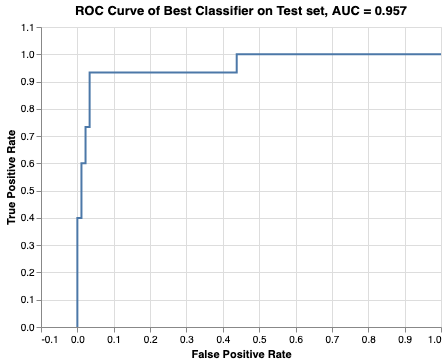

In [183]:
alt.Chart(roc_df).mark_line().encode(
    x = alt.X("False Positive Rate", scale = alt.Scale(domain = [-0.01, 1])),
    y = alt.Y("True Positive Rate", scale = alt.Scale(domain = [0, 1.01])),
).properties(
    title = "ROC Curve of Best Classifier on Test set, AUC = " + str(round(auc_score,3)),
    background = "white"
)

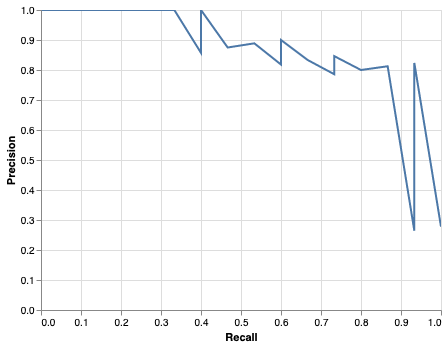

In [163]:
alt.Chart(pr_df).mark_line().encode(
    x = "Recall",
    y = "Precision"
).interactive()

In [172]:
for i, x in enumerate(roc_dfs):
    x["K Fold Iteration"] = i

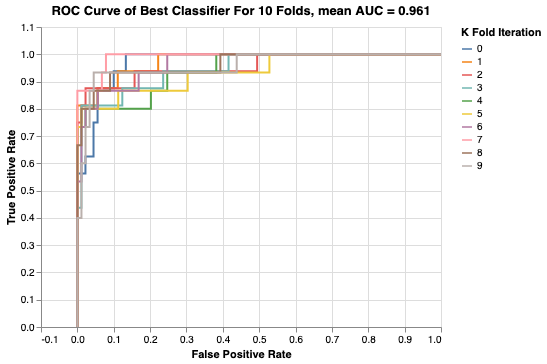

In [182]:
alt.Chart(pd.concat(roc_dfs)).mark_line().encode(
    x = alt.X("False Positive Rate", scale = alt.Scale(domain = [-0.01, 1])),
    y = alt.Y("True Positive Rate", scale = alt.Scale(domain = [0, 1.01])),
    color = "K Fold Iteration:N"
).properties(
    title = "ROC Curve of Best Classifier For 10 Folds, mean AUC = " + str(round(np.mean(aucs),3)),
    background = "white"
)